<a href="https://colab.research.google.com/github/FritzAriza/TDG_Ariza_Roman/blob/main/spectrogram_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de bibliotecas necesarias
%pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
# Importación de bibliotecas
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import soundfile as sf
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Funcion para cargar el audio
def load_audio(file_path):
  sample_rate = 16000
  channels = 1
  audio_binary = tf.io.read_file(file_path)
  try:
    audio, original_sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=channels)
    audio = tf.cast(audio, tf.float32)
    if original_sample_rate != sample_rate:
      audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate
  except tf.errors.InvalidArgumentError as e:
    print(f"Error al decodificar {file_path}: {e}")
    return None, None

# Creacion del espectrograma
def get_spectrogram(waveform):
  target_length = 8000
  waveform_length = tf.shape(waveform)[0]
  padding_length = tf.maximum(0, target_length - waveform_length)
  zero_padding = tf.zeros([padding_length], dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

# Graficar espectrograma
def plot_spectrogram(spectrogram, ax, title):
  log_spec = np.log(spectrogram.T)
  height, width = log_spec.shape
  X = np.linspace(0, width, num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  ax.set_xlim([0, width])
  ax.set_title(title)

In [ ]:
# Espectrograma de colab
def colab_spectrogram(input_path):
  data, samplerate = sf.read(input_path)
  output_path = './rec_fixed.wav'

  sf.write(output_path, data, samplerate)
  waveform, sample_rate = load_audio(output_path)

  spectrogram = get_spectrogram(waveform)

  return spectrogram.numpy()

# Espectrograma de arduino
def arduino_spectrogram(input_path):
  spectrogram = pd.read_csv(input_path, header=None)
  spectrogram = spectrogram.to_numpy()

  return spectrogram

In [ ]:
# Recuerda cambiar el path a la ubicacion donde tengas guardado el audio que quieres probar
# y que sea un archivo .wav
path = '/content/drive/MyDrive/dataset/esp/rec.wav'
ipd.Audio(path, rate=16000)

colab = colab_spectrogram(path)

# Recuerda cambiar la ubicacion donde tengar el archivo .csv
csv_arduino = arduino_spectrogram('/content/drive/MyDrive/dataset/esp/spectrogram.csv')

<ipython-input-4-c27ba2426bcf>:32: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


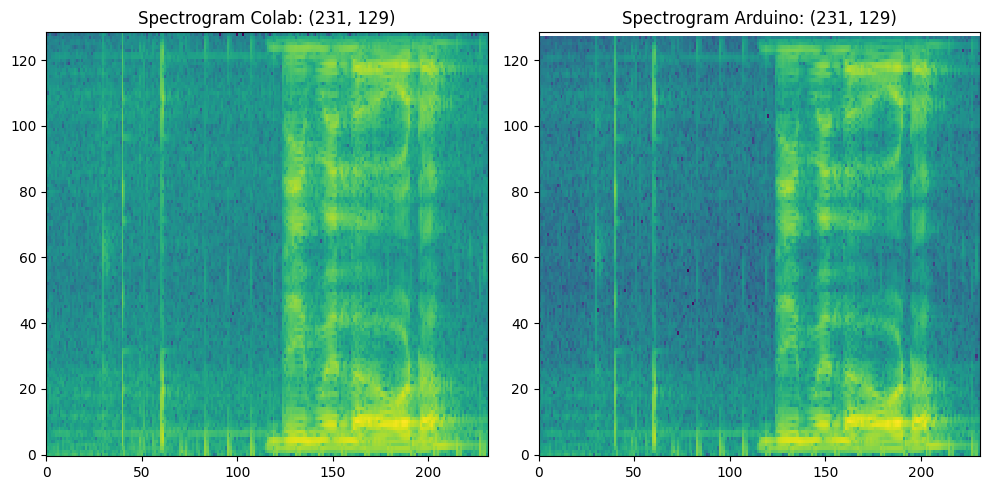

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Crear 1 fila, 2 columnas

# Graficar el primer espectrograma en el primer eje (axs[0])
plot_spectrogram(colab, axs[0], f'Spectrogram Colab: {colab.shape}')

# Graficar el segundo espectrograma en el segundo eje (axs[1])
plot_spectrogram(csv_arduino, axs[1], f'Spectrogram Arduino: {csv_arduino.shape}')

# Mostrar la figura
plt.tight_layout()  # Ajustar el layout para que no haya solapamiento
plt.show()